In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp '/content/drive/My Drive/SKU110K_fixed.tar.gz' '/content/SKU110K.tar.gz'

In [0]:
import tarfile
with tarfile.open('/content/SKU110K.tar.gz') as tar:
    tar.extractall()

In [4]:
import os
len(os.listdir('/content/SKU110K_fixed/images'))

11743

## Importing Libraries

In [0]:
from tensorflow.python.keras.preprocessing.text import Tokenizer
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import cv2
import re

## Loading Train,Test,Val in Data Frame


In [0]:
hImage,wImage=512,512
nClasses=1

def pre_process_data(path):
  colnames=['Img','x1','y1','x2','y2',
            'class','ImgW','ImgH']
  
  annotate_data=pd.read_csv(path,names=colnames)
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(annotate_data['class'])
  idx=tokenizer.word_index

  annotate_data = annotate_data.astype({"x1": float,\
                                        "x2": float,\
                                        "y1": float,\
                                        "y2": float})

  #Resize bb according to image
  annotate_data.iloc[:,1]=(annotate_data.iloc\
                           [:,1]*wImage)/annotate_data.iloc[:,6]
  annotate_data.iloc[:,2]=(annotate_data.iloc\
                           [:,2]*hImage)/annotate_data.iloc[:,7]
  annotate_data.iloc[:,3]=(annotate_data.iloc\
                           [:,3]*wImage)/annotate_data.iloc[:,6]
  annotate_data.iloc[:,4]=(annotate_data.iloc\
                           [:,4]*hImage)/annotate_data.iloc[:,7]
  
  annotate_data.iloc[:,5]=idx['object']
  annotate_data['boxes_x1y1x2y2']=annotate_data\
  [['x1','y1','x2','y2','class']].to_numpy().tolist()

  #Converting to x,y,w,h
  annotate_data.iloc[:,1]=(annotate_data.iloc\
                           [:,1]+annotate_data.iloc[:,3])/2.0
  annotate_data.iloc[:,2]=(annotate_data.iloc\
                           [:,2]+annotate_data.iloc[:,4])/2.0
  annotate_data.iloc[:,3]=(annotate_data.iloc\
                           [:,3]-annotate_data.iloc[:,1])
  annotate_data.iloc[:,4]=(annotate_data.iloc\
                           [:,4]-annotate_data.iloc[:,2])
  annotate_data['boxes_xywh']=annotate_data\
  [['x1','y1','x2','y2','class']].values.tolist()
  annotate_data = annotate_data.groupby('Img').\
  aggregate(lambda tdf: tdf.tolist())
  return annotate_data

## TF Record Write and parse

In [0]:
def read_img(img):
  with tf.io.gfile.GFile(img, 'rb') as fp:
    image = fp.read()
  return image

In [0]:
def wrap_bytes(img):
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[img]))

def wrap_float(value):
  return tf.train.Feature(float_list=tf.train.FloatList(value=value))

out_path='/content/val.tfrecords'
def convert_tfrecord(images,labels,out_path):
  root='/content/SKU110K_fixed/images'
  with tf.io.TFRecordWriter(out_path) as writer:
    for i in range(len(images)):
      label=(np.array(labels[i],dtype=np.float32))
      image=os.path.join(root,images[i])
      img_bytes=read_img(image)
      sku={
            'image':wrap_bytes(img_bytes),
            'x':wrap_float(label[:,0]),
            'y':wrap_float(label[:,1]),
            'w':wrap_float(label[:,2]),
            'h':wrap_float(label[:,3]),
            'class':wrap_float(label[:,4])
      }
      feature=tf.train.Features(feature=sku)
      example=tf.train.Example(features=feature)
      serialized=example.SerializeToString()
      writer.write(serialized)


In [0]:
def convert_back(serialized):  
  feature={
      'image':tf.io.FixedLenFeature([],tf.string),
      'x':tf.io.VarLenFeature(tf.float32),
      'y':tf.io.VarLenFeature(tf.float32),
      'w':tf.io.VarLenFeature(tf.float32),
      'h':tf.io.VarLenFeature(tf.float32),
      'class':tf.io.VarLenFeature(tf.float32)
  }
  parsed_example = tf.io.parse_single_example(serialized=serialized,
                                            features=feature)
  img = tf.io.decode_image(parsed_example['image'],channels=3)
  label=tf.stack([tf.sparse.to_dense(parsed_example['x']),
            tf.sparse.to_dense(parsed_example['y']),
            tf.sparse.to_dense(parsed_example['w']),
            tf.sparse.to_dense(parsed_example['h']),
            tf.sparse.to_dense(parsed_example['class'])],axis=-1)
  return img, label

In [0]:
def create_data(serialized):
  img, label = convert_back(serialized)
  img.set_shape([None, None, 3])
  img=tf.image.resize(img,[512,512])

  #GT boxes creation
  gt_box_conv=convert_format(label[:,:4],'x1y1x2y2')
  iou_matrix=iou(np.expand_dims(feature_box_conv,axis=1),(gt_box_conv))
  gt_box,matched=df_match(label,iou_matrix)
  dfclass=class_df_encode(label,iou_matrix)
  normalised_gtbox=normalised_gt(gt_box,feature_box)
  normalised_gtbox_abs=rel_to_abs(normalised_gtbox)
  df_box=tf.concat((normalised_gtbox_abs,dfclass),axis=1)
  return img,df_box



In [13]:
batch_size=5
epochs=5
files='/content/val.tfrecords'
dataset=tf.data.TFRecordDataset(filenames=files)

dataset = dataset.map(create_data)
for i,l in dataset.take(1):
  print(l[23609,4:])
  for k in range(len(l)):
    if((l[k,4].numpy()) == 1.):
      print(k)


NameError: ignored

In [0]:
#Show img
def show_img(img,label):
  img=cv2.imread(img)
  color=(255,0,0)
  img=cv2.resize(img,(hImage,wImage))
  for i,val in enumerate(label):
    start=tuple((np.array(label[i][:2])).astype('int'))
    end=tuple((np.array(label[i][2:4])).astype('int'))
    cv2.rectangle(img,start,end,color,2)
  cv2_imshow(img)


### Convert boxes x,y,w,h to x1,y1,x2,y2

In [0]:
def convert_format(out,format):
  if format=='x1y1x2y2':
    return tf.stack([out[...,0]-out[...,2]/2.0,
    out[...,0]+out[...,2]/2.0,
    out[...,1]-out[...,3]/2.0,
    out[...,1]+out[...,3]/2.0],axis=-1)
  if format=='xywh':
    return tf.stack([(out[...,0]+out[...,2])/2.0,
    (out[...,1]+out[...,3])/2.0,
    out[...,2]-out[...,0],
    out[...,3]+out[...,1]],axis=-1)

## Creating Default/Anchor Boxes

In [0]:
def create_df_box(feature_layers):
  '''
  #CREATING SCALE
  #Scale of default boxes for each feature layer are computed by 
  #s_min+(s_max-s_min)/(m-1)*(k-1)
  s_min=0.03
  s_max=0.32
  #No. of feature layer
  m=6
  scale=[]

  #Range starting from 2 because we are starting from feature layer 2
  for k in range(2,6):
    sk=s_min+(s_max-s_min)/(m-1)*(k-1)
    scale.append(sk)
  scale.insert(0,s_min)
  scale.extend([s_max])
  '''
  scale = [0.03, 0.05, 0.08, 0.12, 0.15, 0.25, 0.35]
  aspect_ratios= [0.416, 0.553, 0.722, 1.401, 3.131]
  feature_boxes=[]
  for feature_layer in feature_layers:
    #Computing w and h
    '''
    if feature_layer==38 or feature_layer==3\
     or feature_layer==1:
      aspect_ratios=[1,2,1/2]
    else:
      aspect_ratios=[1,2,3,1/2,1/3]
    '''
    w_ar=[]
    h_ar=[]
    for i in aspect_ratios:
      if i==1:
        w=scale[aspect_ratios.index(i)]*np.sqrt(i)
        h=scale[aspect_ratios.index(i)]/np.sqrt(i)
        w_ar.append(w)
        h_ar.append(h)
        sk_1=np.sqrt(scale[aspect_ratios.index(i)]* \
                     scale[aspect_ratios.index(i)+1])
        w=sk_1*np.sqrt(i)
        h=sk_1/np.sqrt(i)
      else:
        w=scale[aspect_ratios.index(i)]*np.sqrt(i)
        h=scale[aspect_ratios.index(i)]/np.sqrt(i)
      w_ar.append(w)
      h_ar.append(h)
    #Computing x and y    
    x_axis=np.linspace(0,feature_layer,feature_layer+1)
    y_axis=np.linspace(0,feature_layer,feature_layer+1)
    xx,yy=np.meshgrid(x_axis,y_axis)
    x=[(i+0.5)/(feature_layer) for i in xx[:-1,:-1]]
    y=[(i+0.5)/(feature_layer) for i in yy[:-1,:-1]]
    '''
    if feature_layer==38 or feature_layer==3 or\
     feature_layer==1:
      ndf_box=4
    else:
      ndf_box=6
    '''
    ndf_box=5
    ndf_boxes=feature_layer*feature_layer*ndf_box
    nbox_coordinates=4
    feature_box=np.zeros((ndf_boxes,nbox_coordinates))
    #x would be 38*38 center for every df box
    x=np.array(x).reshape(feature_layer*feature_layer)
    #We have the same center for 4 default boxes 
    x=np.repeat(x,ndf_box)
    y=np.array(y).reshape(feature_layer*feature_layer)
    y=np.repeat(y,ndf_box)

    #W would be 4*1 or 6*1 based on aspect ratio   
    w_ar=np.tile(w_ar,feature_layer*feature_layer)
    h_ar=np.tile(h_ar,feature_layer*feature_layer)
    feature_box[:,0]=x
    feature_box[:,1]=y
    feature_box[:,2]=w_ar
    feature_box[:,3]=h_ar
    feature_boxes.append(feature_box)
  feature_box=np.concatenate([i for i in feature_boxes],axis=0)
  return feature_box

#### Converting Relative co-ordinates to absolute co-ordinates 

In [0]:
def rel_to_abs(matrix):
  return tf.stack([matrix[:,0]*wImage,
  matrix[:,1]*hImage,
  matrix[:,2]*wImage,
  matrix[:,3]*hImage],axis=-1)


### IOU b/w two boxes

In [0]:
def iou(box1,box2):
  box1=tf.cast(box1,dtype=tf.float32)
  box2=tf.cast(box2,dtype=tf.float32)
  x1=tf.math.maximum(box1[:,:,0],box2[:,0])
  y1=tf.math.maximum(box1[:,:,1],box2[:,1])
  x2=tf.math.minimum(box1[:,:,2],box2[:,2])
  y2=tf.math.minimum(box1[:,:,3],box2[:,3])
  #Intersection area
  print(x1.shape)
  intersectionArea=(x2-x1)*(y2-y1)
  #Union area
  box1Area=(box1[:,:,2]-box1[:,:,0])*\
  (box1[:,:,3]-box1[:,:,1])
  box2Area=(box2[:,2]-box2[:,0])*\
  (box2[:,3]-box2[:,1])
  print(box1Area.shape,box2Area.shape,intersectionArea.shape)
  print((box1Area+box2Area).shape)
  unionArea=box1Area+box2Area-intersectionArea
  print(unionArea.shape)
  iou=intersectionArea/unionArea
  print(tf.clip_by_value(iou,0.0,1.0))
  return tf.clip_by_value(iou,0.0,1.0)


### Matching strategy


In [0]:
def df_match(labels,iou_matrix):
  #No. of ground truth labels
  max_values=tf.reduce_max(iou_matrix,axis=1)
  print(max_values)
  max_idx=tf.math.argmax(iou_matrix,axis=1)
  matched=tf.math.greater_equal(max_values,0.5)
  matched_idx=[i for i,val in \
               enumerate(matched) if val]
  print(len(matched_idx))
  gt_box=tf.gather(labels[:,:4],max_idx)
  return gt_box,matched

### Class Matching Strategy

In [0]:
nClasses=1
#Class encoding matched with default boxes
def class_df_encode(out,iou_matrix):
  max_values=tf.reduce_max(iou_matrix,axis=1)
  max_idx=tf.math.argmax(iou_matrix,axis=1)  
  matched=tf.math.greater_equal(max_values,0.5)
  matched=tf.cast(matched,dtype=tf.int32)
  cls_df=tf.cast(tf.gather(out[:,4],max_idx),dtype=tf.int32)
  cls=tf.cast(matched*cls_df,dtype=tf.int32)  
  dfclass=(tf.one_hot(cls,depth=nClasses+1))
  dfclass=tf.cast(dfclass,dtype=tf.float32)
  return dfclass

In [0]:
wImage,hImage=512,512
#Here x1,y1,x2,y2
def pre_process_img(img,feature_box_conv,matched):
  img=cv2.imread(img)
  img = cv2.resize(img, (hImage,wImage), \
                   interpolation = cv2.INTER_AREA)
  color=(255,0,0)
  matched_idx=[i for i,val in \
               enumerate(matched) if val]
  for i in (matched_idx):
    start=feature_box_conv[i,:2]
    end=feature_box_conv[i,2:]
    start=tuple((start))
    end=tuple((end))
    cv2.rectangle(img,start,end,color,2)
  cv2_imshow(img)
  


### Normalizing Ground Truth Labels

In [0]:
def normalised_gt(matched_boxes,feature_box):
  matched_boxes=tf.cast(matched_boxes,dtype=tf.float32)
  feature_box=tf.cast(feature_box,dtype=tf.float32)
  return tf.stack([
  (matched_boxes[:,0]-feature_box[:,0])/feature_box[:,0],
  (matched_boxes[:,1]-feature_box[:,1])/feature_box[:,1],
  tf.math.log(matched_boxes[:,2]/feature_box[:,2]),
  tf.math.log(matched_boxes[:,3]/feature_box[:,3])],axis=-1)


In [0]:
img_list=[]
for i in os.listdir('/content/SKU110K_fixed/images'):
  img_list.append(i)
b=set(annotate_data.index)-set(img_list)
annotate_data.drop(b,inplace=True)


## Loss

In [0]:
def total_loss(y_true,y_pred):
  y_true=tf.cast(y_true,dtype=tf.float32)
  y_pred=tf.cast(y_pred,dtype=tf.float32)
  pos_mask=tf.equal(y_true[:,:,-4:-3],0.0)
  num_pos=tf.math.count_nonzero(pos_mask)
  loc_loss=(tf.compat.v1.losses.huber_loss
            (y_true[:,:,:4], y_pred[:,:,:4]))
  cce = tf.losses.CategoricalCrossentropy()
  cross_entropy=cce(y_true[:,:,-4:],y_pred[:,:,-4:])
  #neg:pos 3:1
  num_neg=3*num_pos
  #Negative Mining
  neg_cross_entropy=tf.where(tf.not_equal\
                             (pos_mask,1.0),cross_entropy,0.0)
  sorted_dfidx=tf.argsort(neg_cross_entropy,\
                          direction='DESCENDING',axis=1)
  rank=tf.argsort(sorted_dfidx,axis=1)
  neg_loss=tf.where((rank)<num_neg,neg_cross_entropy,0.0)
  pos_loss=tf.where(tf.equal(pos_mask,1.0),cross_entropy,0.0)
  pos_loss=tf.reduce_sum(pos_loss,axis=1)
  clas_loss=tf.reduce_sum(pos_loss+neg_loss)
  totalloss=tf.math.divide_no_nan(
    (loc_loss+clas_loss),num_pos , name='Total_loss')
  return totalloss


## Data Generator

In [0]:
#Data Generator
batch_size=1
epochs=1
def data_gen(files):
  dataset=tf.data.TFRecordDataset(filenames=files)
  dataset = dataset.map(create_data)
  dataset = dataset.shuffle(10000)
  dataset = dataset.batch(batch_size)
  dataset = dataset.repeat(epochs)
  return dataset

## Model

In [0]:
nClasses=1
import tensorflow as tf
def conv_layer(filter,kernel_size,
               layer,strides=1,
               padding='same',
               activation='relu',pool=False,
               poolsize=2,poolstride=2,conv=True):
  if conv == True:
      layer=tf.keras.layers.Conv2D(filters=filter,
                                  kernel_size=kernel_size,
                                  strides=strides,
                                  activation=activation,
                                  padding=padding)(layer)
  if pool == True:
    layer=tf.keras.layers.MaxPool2D(pool_size=(poolsize,poolsize),
                                    strides=poolstride,padding='same')(layer)
  return layer

def ssd_model():
  inputs=tf.keras.layers.Input(shape=(512,512,3))

  #vgg16 was trained on 224,224,3 size images, so creating it for 300,300,3
  #In pool 5 we pass stride = 1 and pool size =2
  #No dropout used
  outputs=[]

  #Feature layer 1 - 38*38*512
  layer = conv_layer(64, 3, inputs)
  layer = conv_layer(64, 3, layer,pool=True)
  layer = conv_layer(128, 3, layer)
  layer = conv_layer(128, 3, layer, pool=True)
  layer = conv_layer(256, 3, layer)
  layer = conv_layer(256, 3, layer)
  layer = conv_layer(256, 3, layer, pool=True)
  layer = conv_layer(512, 3, layer)
  layer = conv_layer(512, 3, layer)
  layer = conv_layer(512, 3, layer)

  output=conv_layer(5*(4+nClasses+1),3,layer)
  output = tf.keras.layers.Reshape([-1, 4+nClasses+1])(output)
  outputs.append(output)

  #Feature layer 2 19*19*1024
  layer = conv_layer(512, 3, layer,pool=True,conv=False)
  layer = conv_layer(512, 3, layer)
  layer = conv_layer(512, 3, layer)
  layer = conv_layer(512, 3 , layer,pool=True, poolsize=3, poolstride=1)
  layer = conv_layer(1024, 3, layer)
  layer = conv_layer(1024, 1, layer)

  output=conv_layer(5*(4+nClasses+1),3,layer)
  output = tf.keras.layers.Reshape([-1, 4+nClasses+1])(output)
  outputs.append(output)

  #Extra Feature Layers

  #Feature Layer 3 10*10*512
  layer = conv_layer(256, 1, layer)
  layer = conv_layer(512, 3, layer, strides=2)
  output=conv_layer(5*(4+nClasses+1),3,layer)
  output = tf.keras.layers.Reshape([-1, 4+nClasses+1])(output)
  outputs.append(output)

  #Feature Layer 4 5*5*256
  layer = conv_layer(128, 1, layer)
  layer = conv_layer(256, 3, layer, strides=2)
  output=conv_layer(5*(4+nClasses+1),3,layer)
  output = tf.keras.layers.Reshape([-1, 4+nClasses+1])(output)
  outputs.append(output)

  #Feature Layer 4 3*3*256
  layer = conv_layer(128, 1, layer,padding= 'valid')
  layer = conv_layer(256, 3, layer,padding= 'valid')
  output=conv_layer(5*(4+nClasses+1),3,layer)
  output = tf.keras.layers.Reshape([-1, 4+nClasses+1])(output)
  outputs.append(output)

  #Feature Layer 4 1*1*256
  layer = conv_layer(128, 1, layer,padding= 'valid')
  layer = conv_layer(256, 3, layer,padding= 'valid')
  output=conv_layer(5*(4+nClasses+1),3,layer)
  print(output)
  output = tf.keras.layers.Reshape([-1, 4+nClasses+1])(output)
  outputs.append(output)

  out = tf.keras.layers.Concatenate(axis=1)(outputs)
  model=tf.keras.models.Model(inputs,out)

  model.summary()
  return

In [0]:
def iou(box1,box2):
  box1=tf.cast(box1,dtype=tf.float32)
  box2=tf.cast(box2,dtype=tf.float32)
  x1=tf.math.maximum(box1[:,:,0],box2[:,0])
  y1=tf.math.maximum(box1[:,:,1],box2[:,1])
  x2=tf.math.minimum(box1[:,:,2],box2[:,2])
  y2=tf.math.minimum(box1[:,:,3],box2[:,3])
  #Intersection area
  print(x1.shape)
  intersectionArea=(x2-x1)*(y2-y1)
  #Union area
  box1Area=(box1[:,:,2]-box1[:,:,0])*\
  (box1[:,:,3]-box1[:,:,1])
  box2Area=(box2[:,2]-box2[:,0])*\
  (box2[:,3]-box2[:,1])
  print(box1Area.shape,box2Area.shape,intersectionArea.shape)
  print((box1Area+box2Area).shape)
  unionArea=box1Area+box2Area-intersectionArea
  print(unionArea.shape)
  iou=intersectionArea/unionArea
  print(iou)
  print(tf.clip_by_value(iou,0.0,1.0))
  return iou


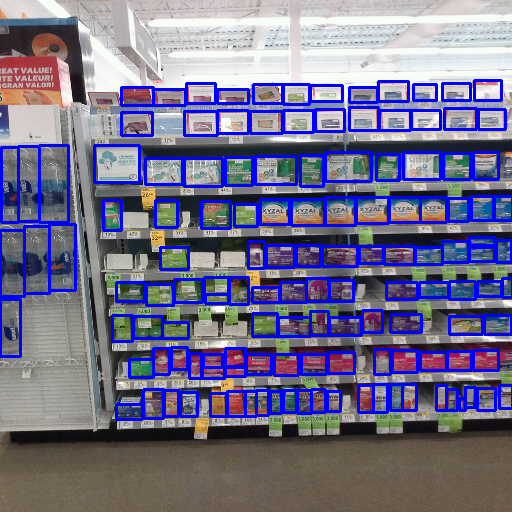

(27460, 132)
(27460, 1) (132,) (27460, 132)
(27460, 132)
(27460, 132)
tf.Tensor(
[[-1.0635568   0.48501492  0.16667296 ... -0.9997054  -1.0041242
  -1.0292658 ]
 [-1.0581176   0.5213536   0.17971122 ... -0.9994793  -1.0038006
  -1.028374  ]
 [-1.0553131   0.5660939   0.19509728 ... -0.99979484 -1.0039454
  -1.0277623 ]
 ...
 [-1.0045506  -0.03632316 -0.02426306 ... -0.9996604  -1.0076439
  -1.0703251 ]
 [-1.0040239   0.05728874  0.03686852 ... -0.99778324 -1.0046462
  -1.0585176 ]
 [-0.988515    0.27849406  0.16207817 ... -0.94773126 -0.9514522
  -0.992257  ]], shape=(27460, 132), dtype=float32)
tf.Tensor(
[[0.         0.48501492 0.16667296 ... 0.         0.         0.        ]
 [0.         0.5213536  0.17971122 ... 0.         0.         0.        ]
 [0.         0.5660939  0.19509728 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.05728874 0.03686852 ... 0.         0.         0.        ]
 [0.         0.2

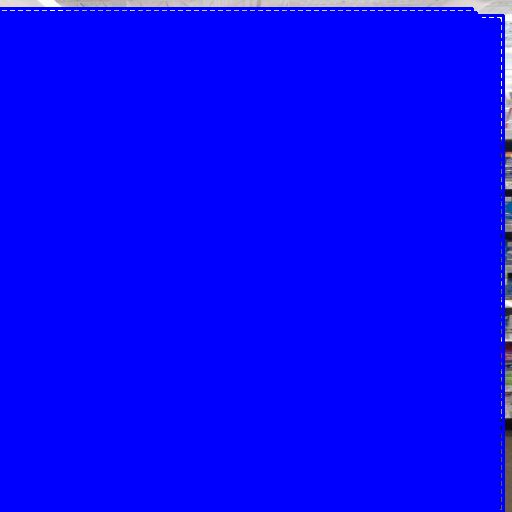

In [28]:
def main(path):
  batch_size=1
  epochs=1
  annotate_data=pre_process_data(path)
  annotate_data=annotate_data[:100]
  img='/content/SKU110K_fixed/images/test_1.jpg'
  label=annotate_data.loc['test_1.jpg']['boxes_x1y1x2y2']
  show_img(img,label)
  feature_layers=[64,32,16,8,6,4]
  feature_box=create_df_box(feature_layers)
  feature_box=rel_to_abs(feature_box)
  feature_box_conv=convert_format(feature_box,'x1y1x2y2')
  gt_box_conv=convert_format(np.array(label),'x1y1x2y2')
  iou_feature_box_conv=np.expand_dims(feature_box_conv,axis=1)
  iou_matrix=iou(iou_feature_box_conv,gt_box_conv)
  gt_box,matched=df_match(np.array(label),iou_matrix)
  pre_process_img(img,feature_box_conv,matched)
  files='/content/val.tfrecords'
  #convert_tfrecord(images,labels,out_path)
  #dataset=data_gen(files)
  #model=ssd_model()

if __name__=='__main__':
  path='/content/SKU110K_fixed/annotations/annotations_test.csv'
  main(path)

In [0]:
## Add to main 
  model.compile(optimizer='adam',metrics=['accuracy'],
              loss=total_loss)
  callback=tf.keras.callbacks.ModelCheckpoint(
          filepath=
          'content/ssd_weights.h5',
          monitor='total_loss',
          save_best_only=True,
          save_weights_only=True,
          mode='min',
          verbose=1)
  step_per_epoch=len(annotate_data)//batch_size
  model.fit_generator(dataset,epochs,step_per_epoch,callbacks=callback)


In [0]:
# Add to main after training. (Testing left)
img,label=pre_process_data(x_test,y_test)
y_pred=model.predict(img)
tf.image.non_max_suppression(
    boxes, scores, max_output_size, iou_threshold=0.5,
    score_threshold=float('-inf'), name=None
)


NameError: ignored